In [33]:
from utils.getter import *
import torch.utils.data as data
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from PIL import Image

train_transforms = Compose([
    #RandomHorizontalFlip(),
    #RandomCrop(),
    #Rotation(20),
    #Resize((300,300)),
    ToTensor(),
    Normalize(),
])

val_transforms = Compose([
    #Resize((300,300)),
    ToTensor(),
    Normalize(),
])

In [3]:
dataset_path = "datasets/datasets/taco/"
img_path = dataset_path + "images"
ann_path = {
    "train": dataset_path + "annotations/taco_train.json",
    "val": dataset_path + "annotations/taco_val.json"}

trainset = ObjectDetectionDataset(img_dir=img_path, ann_path = ann_path['train'],transforms= train_transforms)
valset = ObjectDetectionDataset(img_dir=img_path, ann_path = ann_path['val'],transforms= val_transforms)
print(trainset)
print(valset)

Custom Dataset for Object Detection
-------------------------------
Number of samples: 1350
Number of classes: 60

Custom Dataset for Object Detection
-------------------------------
Number of samples: 150
Number of classes: 60



In [86]:
img_item = trainset.annos['images'][0]
img_id = img_item['id']
img_name = img_item['file_name']
img_anno = [i for i in list(trainset.annos['annotations']) if i['image_id'] == img_id]

img_path = os.path.join(trainset.dir,img_name)
box = np.floor(np.array([i['bbox'] for i in img_anno]))
masks = [np.array(i['segmentation'], dtype=np.int32).reshape(-1,2) for i in img_anno]

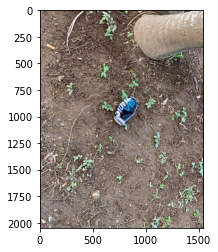

In [74]:
img = Image.open(img_path)
plt.imshow(img)

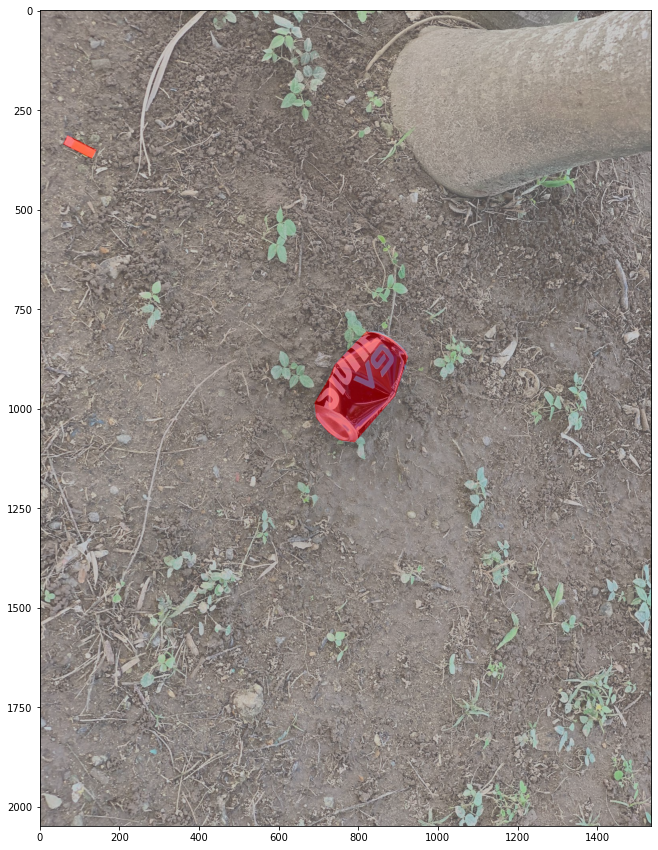

In [87]:
image = Image.open(img_path)

binary_image = np.ones((*img.size[::-1], 3),dtype='int8') * 150
for mask in masks:
    cv2.fillConvexPoly(binary_image, mask, 255)

plt.figure(figsize=(15,15))
plt.imshow(image)
plt.imshow(binary_image, cmap='jet', alpha=0.5)
plt.show()

In [60]:
mask

array([129, 372,  58, 336,  69, 314, 141, 351])

In [70]:

masks 

[array([[129, 372],
        [ 58, 336],
        [ 69, 314],
        [141, 351]]),
 array([[ 689,  985],
        [ 725,  924],
        [ 739,  890],
        [ 818,  807],
        [ 848,  810],
        [ 883,  826],
        [ 915,  854],
        [ 923,  870],
        [ 890,  969],
        [ 789, 1084],
        [ 752, 1079],
        [ 723, 1059],
        [ 693, 1024]])]

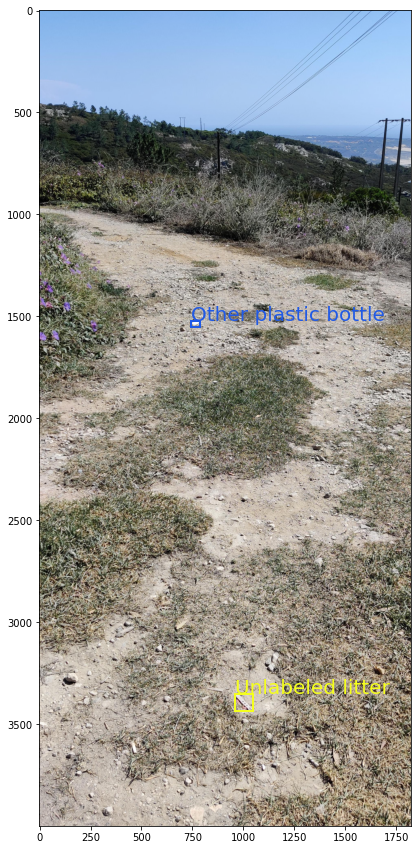

In [5]:
trainset.visualize_item()

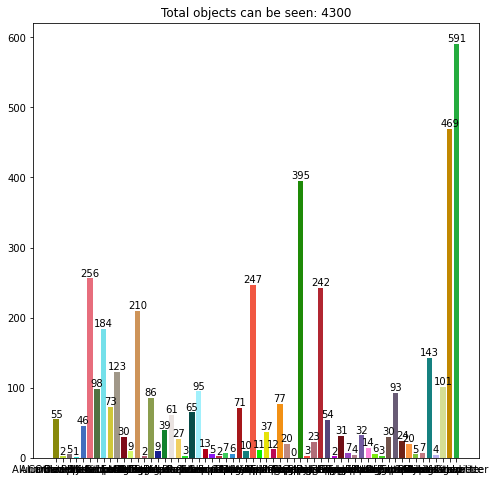

In [6]:
trainset.plot()

In [41]:
NUM_CLASSES = len(trainset.classes)
device = torch.device("cuda")
BATCH_SIZE = 4
my_collate = trainset.collate_fn
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=my_collate, shuffle=True)
valloader = data.DataLoader(valset, batch_size=BATCH_SIZE, collate_fn=my_collate, shuffle=True)

criterion = MultiBoxLoss
optimizer = torch.optim.SGD
#metrics = [AccuracyMetric(decimals=3)]

model = SSDDetector(
                n_classes = NUM_CLASSES,
                optim_params = {'lr': 1e-3, 'momentum': 0.9},
                criterion= criterion, 
                optimizer= optimizer,

                #metrics=  metrics,
                device = device)

load_checkpoint(model, "weights/ssd-voc/SSD300-10.pth")
#model.unfreeze()
trainer = Trainer(model,
                 trainloader, 
                 valloader,
#                     clip_grad = 1.0,
                 checkpoint = Checkpoint(save_per_epoch=5, path = 'weights/ssd-voc'),
                 logger = Logger(log_dir='loggers/runs/ssd-voc'),
                 scheduler = StepLR(model.optimizer, step_size=70, gamma=0.1),
                 evaluate_per_epoch = 2)

result = trainer.inference_batch(valloader)


Loaded base model.

Loaded Successfully!


In [49]:
item = next(iter(valloader))
i = 2
img = item['imgs'][i]
boxes = result['boxes'][i].cpu()
labels = result['labels'][i].cpu().numpy()
scores = result['scores'][i].cpu().numpy()

In [50]:
original_dims = torch.FloatTensor(
        [img.shape[2], img.shape[1], img.shape[2], img.shape[1]]).unsqueeze(0)
boxes = boxes * original_dims
print(boxes)

tensor([[165.2876, 118.2476, 297.0879, 277.2274],
        [ -3.7167,  69.6046, 137.4193, 277.4835],
        [148.4456,  86.0743, 234.0963, 275.6768],
        [ 53.9834,  84.7898, 141.7239, 284.1117],
        [132.4701,  91.7313, 152.4521, 146.5462],
        [155.2747,  95.4878, 182.6130, 144.7952],
        [112.4770,  90.9462, 149.0600, 143.7059]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


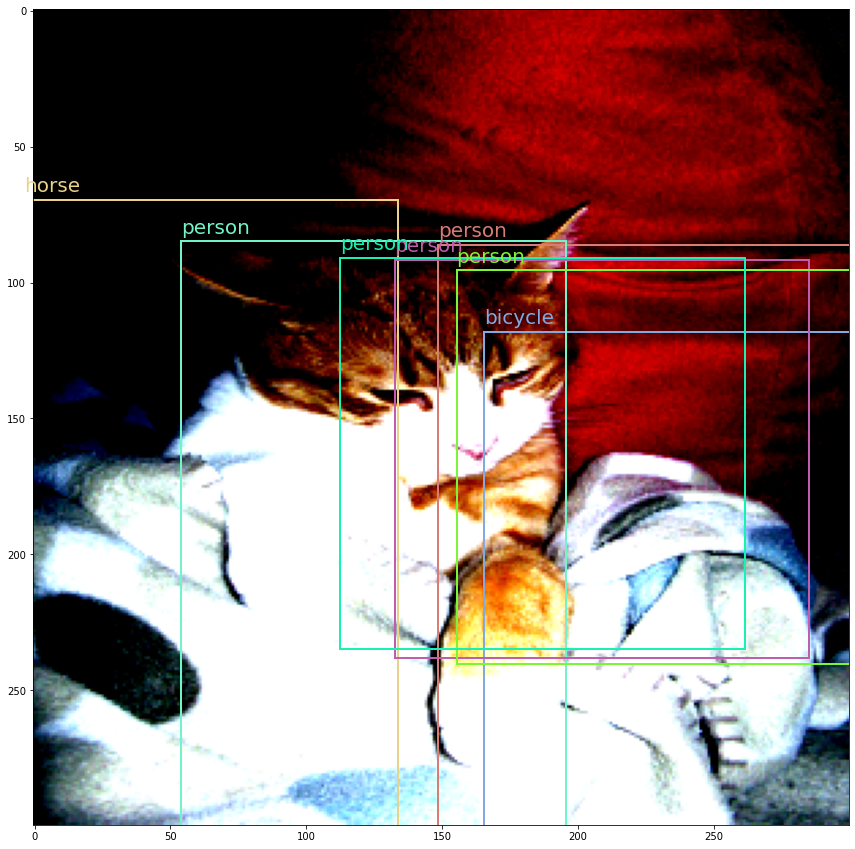

In [51]:
trainset.visualize(img,boxes,labels)